In [134]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Rectangle
import warnings
warnings.filterwarnings('ignore')


In [88]:
import matplotlib.font_manager as font_manager
import matplotlib as mpl
from matplotlib import rcParams

# Definimos path
path = '/home/daniufundar/Documents/Fundar/graficos-indice-desigualdad-genero/'

# Definimos fuente para los graficos
font_dir = [path + 'basemaps/Archivo/']
for font in font_manager.findSystemFonts(font_dir):
    font_manager.fontManager.addfont(font)

rcParams['font.family'] = 'Archivo'

# Definimos colores fundar
fundar_colores_primarios = ['#7BB5C4', '#9FC1AD', '#D3D3E0',  '#8d9bff', '#FF9750', '#FFD900',]
fundar_colores_secundarios = ['#B5E0EA', '#B3B3B3', '#848279', '#AFA36E', '#5D896F', '#9C9CBC', '#E27124']
fundar_white = '#F5F5F5'
fundar_black = '#151515'

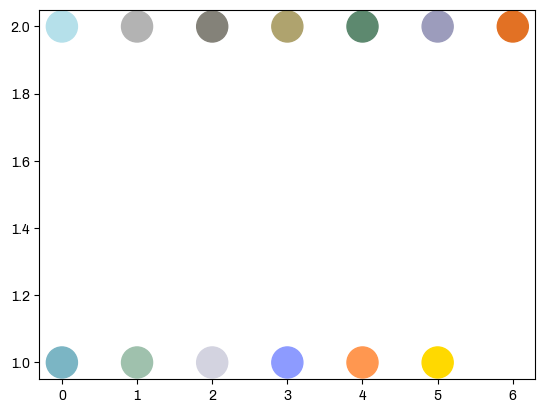

In [123]:
import matplotlib.colors as mcolors

rgba_colors = [mcolors.to_rgba(color) for color in fundar_colores_primarios]
x = np.arange(len(fundar_colores_primarios))
y = [1]*len(fundar_colores_primarios)
plt.scatter(x, y, s=500, color=rgba_colors)

rgba_colors = [mcolors.to_rgba(color) for color in fundar_colores_secundarios]
x = np.arange(len(fundar_colores_secundarios))
y = [2]*len(fundar_colores_secundarios)
plt.scatter(x, y, s=500, color=rgba_colors)

plt.show()

In [3]:
pathdata = '/home/daniu/Documentos/fundar/indice-mercado-trabajo-ingresos/'
pathdata = '/Users/danielarisaro/Documents/fundar/indice-mercado-trabajo-ingresos/'
pathdata = '/home/daniufundar/Documents/Fundar/indice-mercado-trabajo-ingresos/'


df_people_2016 = pd.read_csv(pathdata + 'data_input/personas_tot_urb_3T_16.txt', delimiter=';', low_memory=False)
df_people_2017 = pd.read_csv(pathdata + 'data_input/personas_tot_urb_3T_17.txt', delimiter=';', low_memory=False)
df_people_2018 = pd.read_csv(pathdata + 'data_input/personas_tot_urb_3T_18.txt', delimiter=';', low_memory=False)
df_people_2019 = pd.read_csv(pathdata + 'data_input/personas_tot_urb_3T_19.txt', delimiter=';', low_memory=False)
df_people_2020 = pd.read_csv(pathdata + 'data_input/personas_tot_urb_3T_20.txt', delimiter=';', low_memory=False)
df_people_2021 = pd.read_csv(pathdata + 'data_input/personas_tot_urb_3T_21.txt', delimiter=';', low_memory=False)
df_people_2022 = pd.read_csv(pathdata + 'data_input/personas_tot_urb_3T_22.txt', delimiter=';', low_memory=False)

In [4]:
import numpy as np
import pandas as pd

def generate_table(df_people):
    # Calculate total population
    pob = df_people['PONDERA'].sum()

    # Calculate number of observations
    cantidad_observaciones = len(df_people)

    # Calculate number of surveys performed
    encuesta_realizada = df_people[df_people['H15'] == 1]['H15'].count()
    pob_encuesta_realizada = df_people[df_people['H15'] == 1]['PONDERA'].sum()

    # Calculate number of imputed surveys
    encuesta_imputada = df_people[df_people['IMPUTA']==1]['IMPUTA'].count()
    pob_encuesta_imputada = df_people[df_people['IMPUTA'] == 1]['PONDERA'].sum()

    # Create the table as a pandas dataframe
    data = {'Parameter': ['Population', 'Number of Observations', 'Number of Surveys Performed', 'Population of Surveys Performed', 'Number of Imputed Surveys', 'Population of Imputed Surveys'],
            'Value': [pob, cantidad_observaciones, encuesta_realizada, pob_encuesta_realizada, encuesta_imputada, pob_encuesta_imputada]}
    table = pd.DataFrame(data)
    table.set_index('Parameter', inplace=True)
    
    return table

In [5]:
# Initialize an empty list to store the tables
tables = []

# Loop through the years
for year in range(16, 23):
    # Load the data for the year
    data_file = pathdata + f"data_input/personas_tot_urb_3T_{year}.txt"
    df_people = pd.read_csv(data_file, delimiter=';', low_memory=False)
    
    # Generate the table for the year
    table = generate_table(df_people)
    
    # Add the table to the list with the year as the key
    tables.append((str(year), table))

# Concatenate the tables horizontally
concatenated_df = pd.concat(dict(tables), axis=1)

<AxesSubplot:>

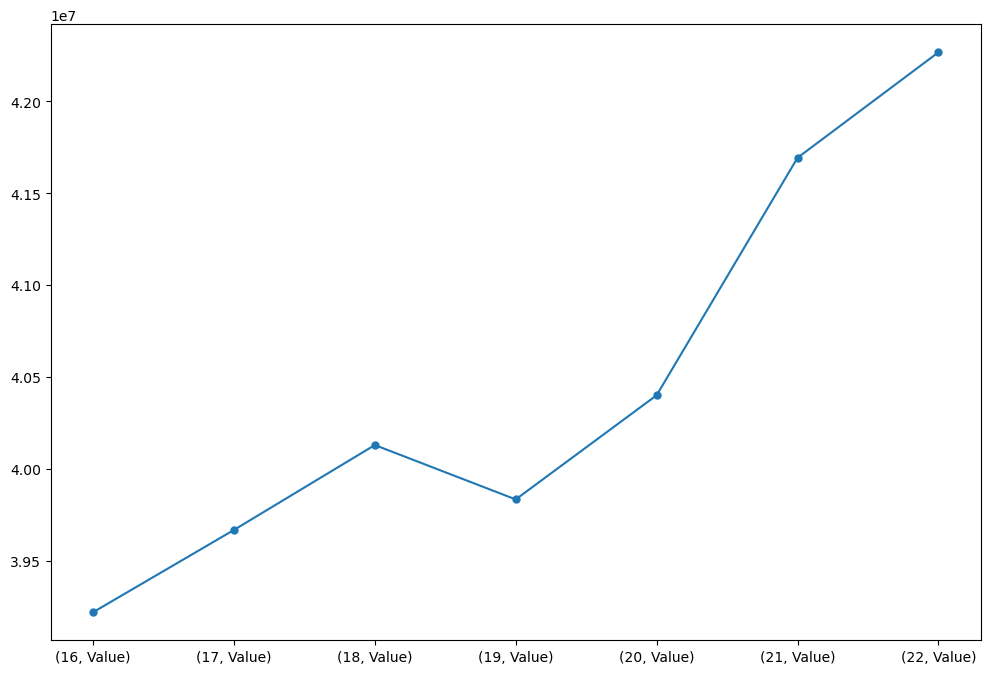

In [6]:
plt.figure(figsize=(12,8))
concatenated_df.loc['Population'].plot(marker='.', markersize=10)

In [7]:
concatenated_df

,16,17,18,19,20,21,22
,Value,Value,Value,Value,Value,Value,Value
Parameter,,,,,,,
Population,39218146,39666414,40128882,39832799,40399992,41693498,42268056
Number of Observations,95782,93891,90807,88949,63162,78217,77642
Number of Surveys Performed,81134,79818,77090,75708,54458,67764,67418
Population of Surveys Performed,33241721,33722644,34186673,34073501,34019917,35320840,36015455
Number of Imputed Surveys,192,144,116,96,56,110,109
Population of Imputed Surveys,151628,145052,124367,96049,92684,210549,142860


In [21]:
merged_df = pd.merge(df_people_2021[['CODUSU', 'COMPONENTE']], df_people_2022[['CODUSU', 'COMPONENTE']], on=['CODUSU', 'COMPONENTE'], how='outer', indicator=True)

# Count the number of duplicate rows
duplicated_rows = merged_df['_merge'].value_counts()['both']
print(f"Number of duplicate rows: {duplicated_rows}")

# Display the left-only rows (2021)
left_only_rows = merged_df['_merge'].value_counts()['left_only']
print(f"Left-only rows: {left_only_rows}")

# Display the right-only rows (2022)
right_only_rows = merged_df['_merge'].value_counts()['right_only']
print(f"Right-only rows: {right_only_rows}")

# Select the right-only and right observation from both rows in merged_df
right_only_rows = merged_df[merged_df['_merge'] == 'right_only']
left_only_rows = merged_df[merged_df['_merge'] == 'left_only']
both_rows = merged_df[merged_df['_merge'] == 'both']
right_both_rows = pd.concat([both_rows, right_only_rows])

# Option 1: Merge two dataframes with "copies"
df_people_2021['rel_PONDERA'] = df_people_2021['PONDERA']/df_people_2021['PONDERA'].sum()
df_people_2022['rel_PONDERA'] = df_people_2022['PONDERA']/df_people_2022['PONDERA'].sum()

df_merged_with_copies = pd.concat([df_people_2021, df_people_2022])

# Option 2: Merge two dataframes erasing the first copy (keeping right only and right both observations)
df_people_2021_no_dupl = pd.merge(left_only_rows, df_people_2021, on=["CODUSU", "COMPONENTE"], how='inner')
df_people_2022_no_dupl = pd.merge(right_both_rows, df_people_2022, on=["CODUSU", "COMPONENTE"], how='inner')

df_merged_without_copies = pd.concat([df_people_2021_no_dupl, df_people_2022_no_dupl])


# Length of resulting dataframes
n_with_copies = len(df_merged_with_copies)
n_without_copies = len(df_merged_without_copies)
print(f"La longitud de los dataframes con y sin replicas son {n_with_copies, n_without_copies}")

Number of duplicate rows: 30417
Left-only rows: 48100
Right-only rows: 47523
La longitud de los dataframes con y sin replicas son (155859, 127958)


In [ ]:
def calculate_bin_width(data, num_bins):
    bin_edges = np.histogram_bin_edges(data, bins=num_bins)
    bin_widths = np.diff(bin_edges)
    return bin_widths[0]

In [98]:
def calculate_grouped_income(df, year):
    income = df[['CH04','P47T','PONDII','PONDERA']].copy()
    income['gender'] = np.where(income['CH04']==1, 'male', 'female')
    income_grouped = income.groupby(['P47T', 'gender'], as_index=False).agg({'PONDII': 'sum'}).sort_values(by='P47T', ascending=True).dropna()
    income_grouped.columns = ['income', 'gender', 'weights']
    income_grouped['year'] = year

    return income_grouped

In [99]:
income_2021_grouped = calculate_grouped_income(df_people_2021, 2021)
income_2022_grouped = calculate_grouped_income(df_people_2022, 2022)

# Hay poco n poblacional representando a los que mas ganan. Si los sacamos, estariamos subestimando aun mas ese fenomeno

In [127]:
def plot_income_histogram(income_df, x0, x1, y0, y1, filename):
    
    fig = plt.figure(figsize=(12, 6))
    ax = plt.axes([0.05, 0.05, 0.85, 0.85])
    ax.spines.right.set_visible(False)
    ax.spines.top.set_visible(False)
    sns.histplot(data=income_df, x='income', weights='weights', bins=400, ax=ax, color=fundar_colores_primarios[4]) # intervalo de 10k pesos
    ax.set_xlabel('Ingreso')
    ax.set_ylabel('Cantidad de personas')
    ax.set_xlim([-1e4, 4.5e6])
    ax.set_ylim([0, 2e7])

    bx = plt.axes([0.35, 0.3, 0.55, 0.55])
    sns.histplot(data=income_df[income_df['income']!=0], x='income', weights='weights', bins=800, ax=bx, color=fundar_colores_primarios[4]) # intervalo de 5k pesos
    bx.set_xlim([x0, x1])
    bx.set_ylim([y0, y1])
    bx.set_ylabel('Cantidad de personas')
    bx.set_xlabel('Ingreso')

    # create rectangle patch object
    rect = Rectangle((x0, y0), x1-x0, y1-y0, linewidth=1, edgecolor='r', facecolor='none')
    # add rectangle to plot
    ax.add_patch(rect)

    # add markers for mean, median, and quartiles
    mean_salary = income_df['income'].mean()
    median_salary = income_df['income'].median()
    q1_salary = income_df['income'].quantile(0.25)
    q3_salary = income_df['income'].quantile(0.75)

    bx.axvline(mean_salary, color=fundar_colores_secundarios[5], linestyle='--', label='Mean')
    bx.axvline(median_salary, color=fundar_colores_secundarios[4], linestyle='--', label='Median')
    bx.axvline(q1_salary, color=fundar_black, linestyle='-', label='Q1')
    bx.axvline(q3_salary, color=fundar_black, linestyle='-', label='Q3')

    plt.ticklabel_format(style='sci', axis='both')

    fig.savefig(filename + '.png', dpi=300, bbox_inches='tight')
    fig.savefig(filename + '.pdf', bbox_inches='tight')


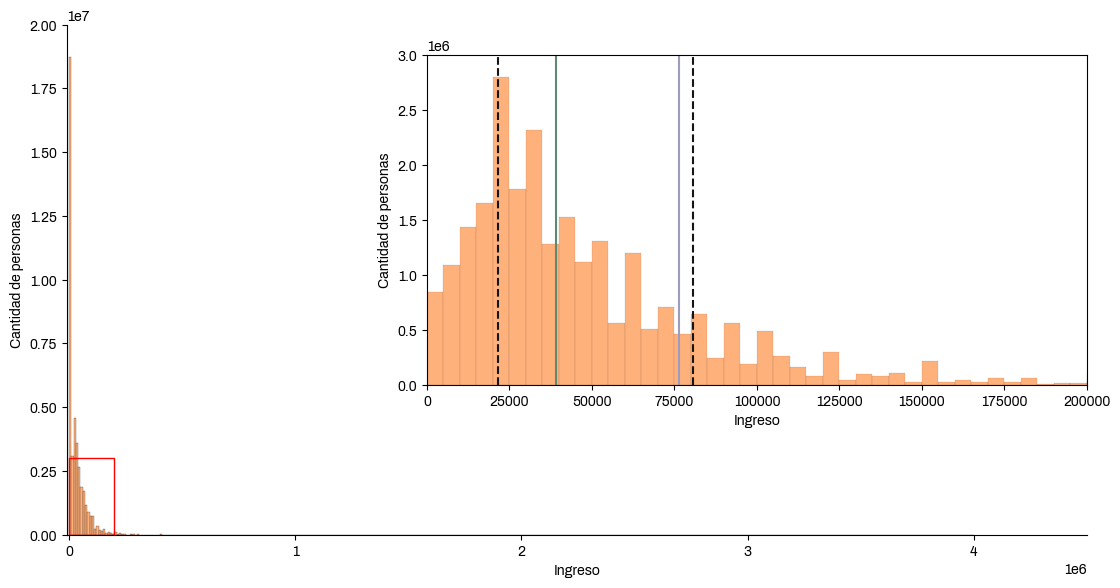

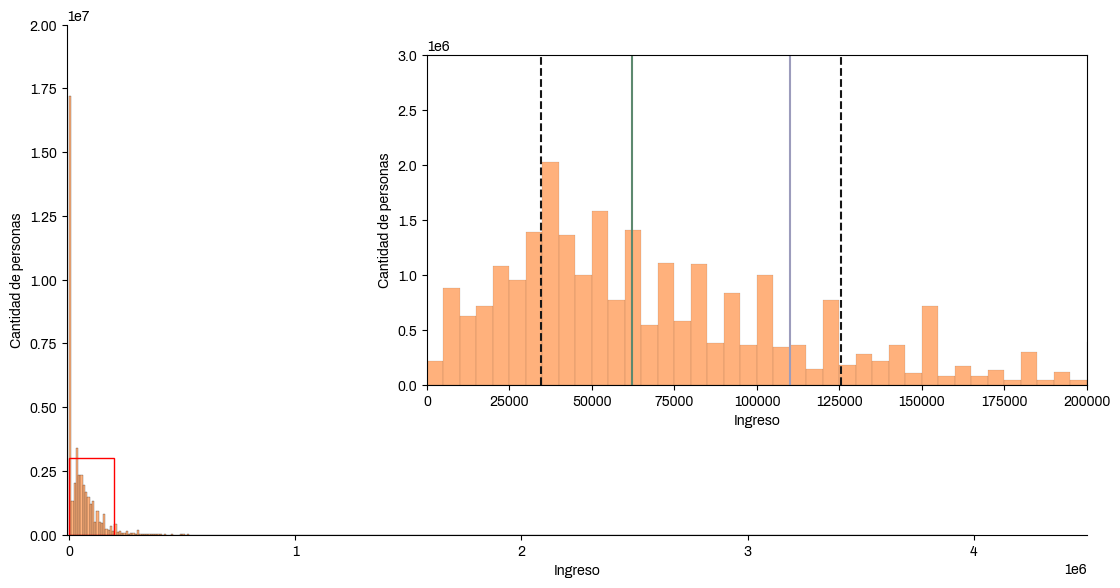

In [126]:
pathfigs = '/home/daniufundar/Documents/Fundar/indice-mercado-trabajo-ingresos/figs/'

plot_income_histogram(income_2021_grouped, 0, 200000, 0, 3000000, pathfigs + 'distribucion-ingreso-2021')
plot_income_histogram(income_2022_grouped, 0, 200000, 0, 3000000, pathfigs + 'distribucion-ingreso-2022')

In [137]:
def plot_income_histogram_male(income_df, x0, x1, y0, y1, filename):
    
    fig = plt.figure(figsize=(12, 6))
    ax = plt.axes([0.05, 0.05, 0.85, 0.85])
    ax.spines.right.set_visible(False)
    ax.spines.top.set_visible(False)
    
    male_df = income_df[income_df['gender'] == 'male']

    sns.histplot(data=male_df, x='income', weights='weights', bins=400, ax=ax, color=fundar_colores_primarios[0]) # intervalo de 10k pesos
    ax.set_xlabel('Ingreso')
    ax.set_ylabel('Cantidad de personas')
    ax.set_xlim([-1e4, 4.5e6])
    ax.set_ylim([0, 2e7])

    bx = plt.axes([0.35, 0.3, 0.55, 0.55])
    sns.histplot(data=male_df[income_df['income']!=0], x='income', weights='weights', bins=800, ax=bx, color=fundar_colores_primarios[0]) # intervalo de 5k pesos
    bx.set_xlim([x0, x1])
    bx.set_ylim([y0, y1])
    bx.set_ylabel('Cantidad de personas')
    bx.set_xlabel('Ingreso')

    # create rectangle patch object
    rect = Rectangle((x0, y0), x1-x0, y1-y0, linewidth=1, edgecolor='r', facecolor='none')
    # add rectangle to plot
    ax.add_patch(rect)

    # add markers for mean, median, and quartiles
    mean_salary = male_df['income'].mean()
    median_salary = male_df['income'].median()
    q1_salary = male_df['income'].quantile(0.25)
    q3_salary = male_df['income'].quantile(0.75)

    bx.axvline(mean_salary, color=fundar_colores_secundarios[5], linestyle='--', label='Mean')
    bx.axvline(median_salary, color=fundar_colores_secundarios[4], linestyle='--', label='Median')
    bx.axvline(q1_salary, color=fundar_black, linestyle='-', label='Q1')
    bx.axvline(q3_salary, color=fundar_black, linestyle='-', label='Q3')

    plt.ticklabel_format(style='sci', axis='both')

    fig.savefig(filename + '.png', dpi=300, bbox_inches='tight')
    fig.savefig(filename + '.pdf', bbox_inches='tight')

def plot_income_histogram_female(income_df, x0, x1, y0, y1, filename):
    
    fig = plt.figure(figsize=(12, 6))
    ax = plt.axes([0.05, 0.05, 0.85, 0.85])
    ax.spines.right.set_visible(False)
    ax.spines.top.set_visible(False)
    
    female_df = income_df[income_df['gender'] == 'female']

    sns.histplot(data=female_df, x='income', weights='weights', bins=400, ax=ax, color=fundar_colores_primarios[3]) # intervalo de 10k pesos
    ax.set_xlabel('Ingreso')
    ax.set_ylabel('Cantidad de personas')
    ax.set_xlim([-1e4, 4.5e6])
    ax.set_ylim([0, 2e7])

    bx = plt.axes([0.35, 0.3, 0.55, 0.55])
    sns.histplot(data=female_df[income_df['income']!=0], x='income', weights='weights', bins=800, ax=bx, color=fundar_colores_primarios[3]) # intervalo de 5k pesos
    bx.set_xlim([x0, x1])
    bx.set_ylim([y0, y1])
    bx.set_ylabel('Cantidad de personas')
    bx.set_xlabel('Ingreso')

    # create rectangle patch object
    rect = Rectangle((x0, y0), x1-x0, y1-y0, linewidth=1, edgecolor='r', facecolor='none')
    # add rectangle to plot
    ax.add_patch(rect)

    # add markers for mean, median, and quartiles
    mean_salary = female_df['income'].mean()
    median_salary = female_df['income'].median()
    q1_salary = female_df['income'].quantile(0.25)
    q3_salary = female_df['income'].quantile(0.75)

    bx.axvline(mean_salary, color=fundar_colores_secundarios[5], linestyle='-', label='Mean')
    bx.axvline(median_salary, color=fundar_colores_secundarios[4], linestyle='-', label='Median')
    bx.axvline(q1_salary, color=fundar_black, linestyle='--', label='Q1')
    bx.axvline(q3_salary, color=fundar_black, linestyle='--', label='Q3')

    plt.ticklabel_format(style='sci', axis='both')

    fig.savefig(filename + '.png', dpi=300, bbox_inches='tight')
    fig.savefig(filename + '.pdf', bbox_inches='tight')



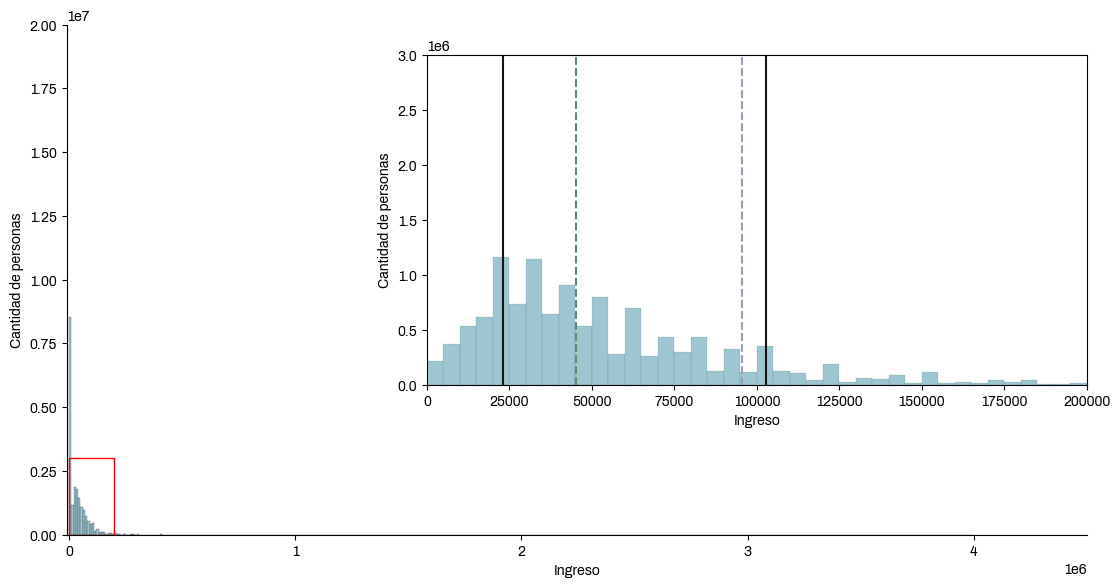

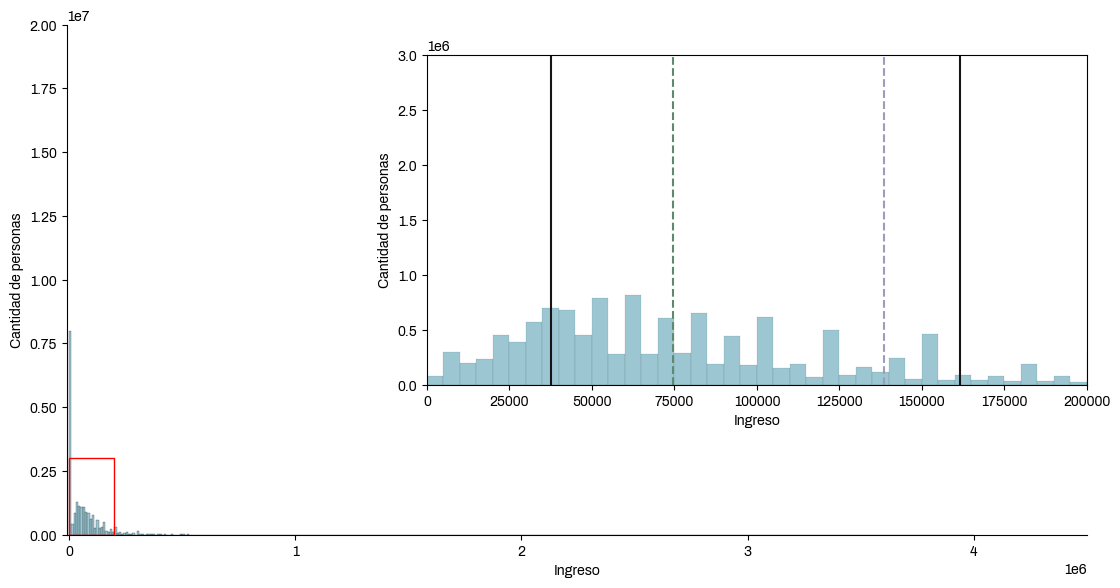

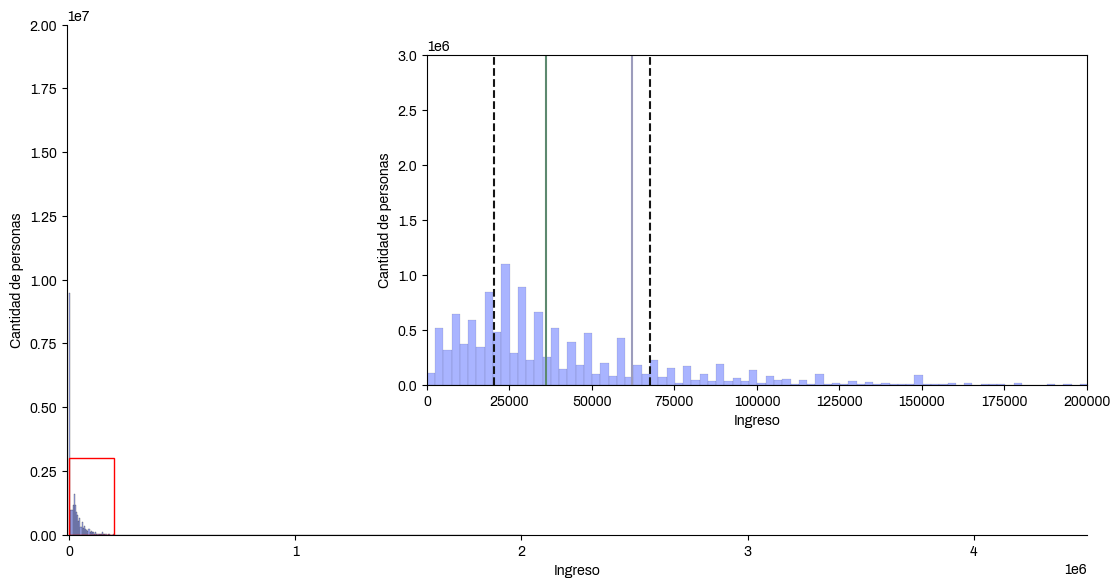

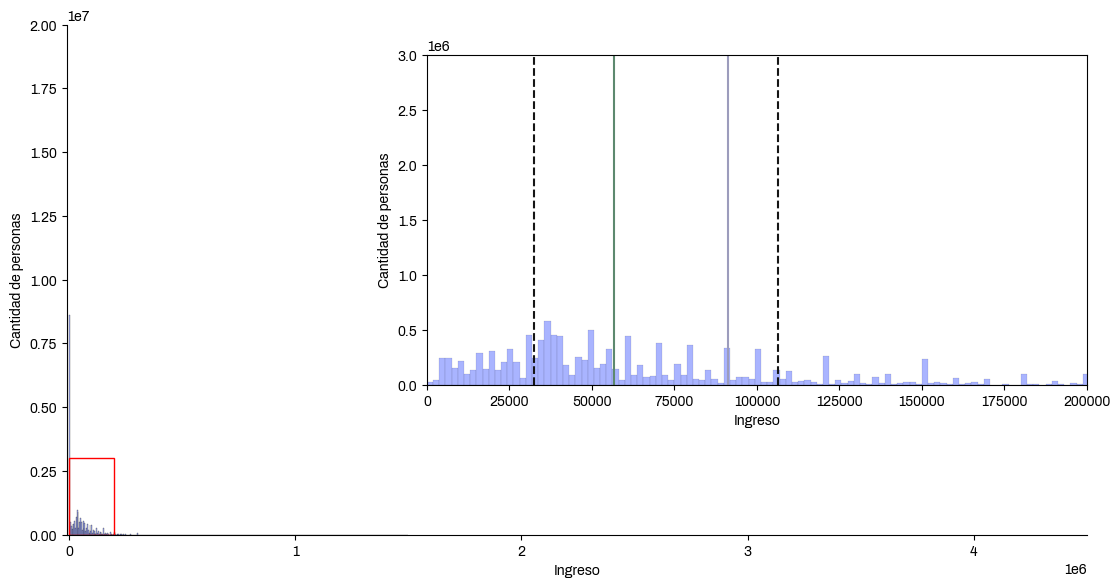

In [138]:
pathfigs = '/home/daniufundar/Documents/Fundar/indice-mercado-trabajo-ingresos/figs/'

plot_income_histogram_male(income_2021_grouped, 0, 200000, 0, 3000000, pathfigs + 'distribucion-ingreso-male-2021')
plot_income_histogram_male(income_2022_grouped, 0, 200000, 0, 3000000, pathfigs + 'distribucion-ingreso-male-2022')

plot_income_histogram_female(income_2021_grouped, 0, 200000, 0, 3000000, pathfigs + 'distribucion-ingreso-female-2021')
plot_income_histogram_female(income_2022_grouped, 0, 200000, 0, 3000000, pathfigs + 'distribucion-ingreso-female-2022')

In [140]:
#cod_provincia
dict_cod_provincia = {2: "Ciudad de Buenos Aires",
 6: "Buenos Aires",
 10: "Catamarca",
 14: "Córdoba",
 18: "Corrientes",
 22: "Chaco",
 26: "Chubut",
 30: "Entre Ríos",
 34: "Formosa",
 38: "Jujuy",
 42: "La Pampa",
 46: "La Rioja",
 50: "Mendoza",
 54: "Misiones",
 58: "Neuquén",
 62: "Río Negro",
 66: "Salta",
 70: "San Juan",
 74: "San Luis",
 78: "Santa Cruz",
 82: "Santa Fe",
 86: "Santiago del Estero",
 90: "Tucumán",
 94: "Tierra del Fuego"}

In [146]:
## Defino funciones dimension mercado de trabajo e ingresos

# Componente: Inserción laboral

# T1. 
# Variable: Actividad productiva
# Indicador: Ratio M/V en tasa de empleo

def ratio_tasa_empleo(df, tipo='Aglomerado', base='Individual'):

    """
    INPUTS
    df: DataFrame. Tabla input EPH
    tipo: string. Tipo de encuesta de la EPH, Aglomerado o Urbano. Default Aglomerado
    base: string. Tipo de base de la encuesta de la EPH, Individual u Hogar. Default Individual

    OUTPUTS
    ratio: DataFrame. Tabla con Ratios en tasa de empleo M/V desagregado por Aglomerado o Provincia
    error: DataFrame. Tabla con los errores asociados a los Ratios

    """

    # Check if the necessary columns exist in the input DataFrame
    if not all(col in df.columns for col in ['CH04', 'CH06', 'ESTADO', 'PONDERA']):
        raise ValueError("El DataFrame de entrada debe tener las siguientes columnas: 'CH04', 'CH06', 'ESTADO', 'PONDERA'")
        
    # Check if the input value of "tipo" is valid
    if tipo not in ['Aglomerado', 'Urbano']:
        return None, 'Error: tipo debe ser "Aglomerado" o "Urbano"'
    if base not in ['Individual', 'Hogar']:
        return None, 'Error: base debe ser "Individual" o "Hogar"'
    if not isinstance(df, pd.DataFrame):
        return None, 'Error: df debe ser un DataFrame de pandas'

    if tipo=='Aglomerado':
        var = 'AGLOMERADO' 
    elif tipo=='Urbano':
        var = 'PROVINCIA'

    df_temp = df.query('CH06 >= 16 & CH06 < 65')
    numerador = df_temp[df_temp['ESTADO']==1].groupby(['CH04', var])['PONDERA'].sum()       # agrupo por genero y provincia y sumo
    
    denominador = df_temp.groupby(['CH04', var])['PONDERA'].sum()
    df_tasa = numerador.div(denominador, fill_value=np.nan)
    df_tasa = df_tasa.to_frame().unstack(level=0)  
    
    ratio = (df_tasa['PONDERA'][2]/df_tasa['PONDERA'][1] * 100).to_frame()
    ratio.rename(columns={0: 'Actividad productiva'}, inplace=True)

    # Calculate error

    error = pd.DataFrame(index=ratio.index)

    return ratio, error


# T2. 
# Variable: Búsqueda de trabajo
# Indicador: Ratio M/V en tasa de desempleo

def ratio_tasa_desempleo(df, tipo='Aglomerado', base='Individual'):

    """
    INPUTS
    df: DataFrame. Tabla input EPH
    tipo: string. Tipo de encuesta de la EPH, Aglomerado o Urbano. Default Aglomerado
    base: string. Tipo de base de la encuesta de la EPH, Individual u Hogar. Default Individual

    OUTPUTS
    ratio: DataFrame. Tabla con Ratios en tasa de desempleo M/V desagregado por Aglomerado o Provincia
    error: DataFrame. Tabla con los errores asociados a los Ratios

    """
    # Check if the necessary columns exist in the input DataFrame
    if not all(col in df.columns for col in ['CH04', 'CH06', 'ESTADO', 'PONDERA']):
        raise ValueError("The input DataFrame must have the following columns: 'CH04', 'CH06', 'ESTADO', 'PONDERA'")
        
    # Check if the input value of "tipo" is valid
    if tipo not in ['Aglomerado', 'Urbano']:
        return None, 'Error: tipo debe ser "Aglomerado" o "Urbano"'
    if base not in ['Individual', 'Hogar']:
        return None, 'Error: base debe ser "Individual" o "Hogar"'
    if not isinstance(df, pd.DataFrame):
        return None, 'Error: df debe ser un DataFrame de pandas'

    if tipo=='Aglomerado':
        var = 'AGLOMERADO' 
    elif tipo=='Urbano':
        var = 'PROVINCIA'

    df_temp = df.query('CH06 >= 16 & CH06 < 65')                                           
    numerador = df_temp[df_temp['ESTADO']==2].groupby(['CH04', var])['PONDERA'].sum()               # agrupo por genero y provincia y sumo
    df_estado = df_temp[(df_temp['ESTADO'] == 1) | (df_temp['ESTADO'] == 2)]                        # selecciona las filas donde la columna ESTADO tenga un valor igual a 1 o 2 (personas activas)
    denominador = df_estado.groupby(['CH04', var])['PONDERA'].sum()                                 # agrupo por genero y provincia y sumo
    df_tasa = (numerador / denominador).to_frame().unstack(level=0)                                 # calculo tasa

    ratio = (df_tasa['PONDERA'][1]/df_tasa['PONDERA'][2] * 100).to_frame()                          # el ratio es V/M para que quede elevado a la menos 1
    ratio.rename(columns={0: 'Búsqueda de trabajo'}, inplace=True)

    error = 'a definir'

    return ratio, error

# T3.
# Variable: Acceso a derechos laborales
# Indicador: Ratio M/V en tasa de empleo asalariado con descuento jubilatorio

def ratio_tasa_registro(df, tipo='Aglomerado', base='Individual'):

    """
    INPUTS
    df: DataFrame. Tabla input EPH
    tipo: string. Tipo de encuesta de la EPH, Aglomerado o Urbano. Default Aglomerado
    base: string. Tipo de base de la encuesta de la EPH, Individual u Hogar. Default Individual

    OUTPUTS
    ratio: DataFrame. Tabla con Ratios en tasa de informalidad M/V desagregado por Aglomerado o Provincia
    error: DataFrame. Tabla con los errores asociados a los Ratios

    """

    # Check if the necessary columns exist in the input DataFrame
    if not all(col in df.columns for col in ['CH04', 'CH06', 'ESTADO', 'PONDERA', 'CAT_OCUP', 'PP07H']):
        raise ValueError("The input DataFrame must have the following columns: 'CH04', 'CH06', 'ESTADO', 'PONDERA', 'CAT_OCUP', 'PP07H'")
        
    # Check if the input value of "tipo" is valid
    if tipo not in ['Aglomerado', 'Urbano']:
        return None, 'Error: tipo debe ser "Aglomerado" o "Urbano"'
    if base not in ['Individual', 'Hogar']:
        return None, 'Error: base debe ser "Individual" o "Hogar"'
    if not isinstance(df, pd.DataFrame):
        return None, 'Error: df debe ser un DataFrame de pandas'

    if tipo=='Aglomerado':
        var = 'AGLOMERADO' 
    elif tipo=='Urbano':
        var = 'PROVINCIA'

    df_temp = df.query('CH06 >= 16 & CH06 < 65')
    df_estado = df_temp[(df_temp['ESTADO']==1) & (df_temp['CAT_OCUP']==3)]                      # Población ocupada asalariada
    numerador = df_estado[df_estado['PP07H']==1].groupby(['CH04', var])['PONDERA'].sum()        # Población ocupada asalariada con descuento jubilatorio
    denominador = df_estado.groupby(['CH04', var])['PONDERA'].sum()
    df_tasa = (numerador / denominador).to_frame().unstack(level=0)                             # calculo tasa

    ratio = (df_tasa['PONDERA'][2]/df_tasa['PONDERA'][1] * 100).to_frame()                      # Calculo ratio
    ratio.rename(columns={0: 'Acceso a derechos laborales'}, inplace=True)

    error = pd.DataFrame(index=ratio.index)
    error = 'a definir'

    # for i in ratio.index:
    #     if denominador[i] == 0:
    #         error[i] = 'Warning: El denominador es cero, no se puede calcular el ratio'
    #     else:
    #         error[i] = np.sqrt((ratio[i]*(1-ratio[i])/denominador[i]))

    return ratio, error

# T4. 
# Variable: Participación en el trabajo remunerado
# Indicador: Ratio M/V en Horas semanales promedio destinadas al trabajo remunerado

def ratio_tasa_horas_remuneradas(df, tipo='Aglomerado', base='Individual'):

    """
    INPUTS
    df: DataFrame. Tabla input EPH
    tipo: string. Tipo de encuesta de la EPH, Aglomerado o Urbano. Default Aglomerado
    base: string. Tipo de base de la encuesta de la EPH, Individual u Hogar. Default Individual

    OUTPUTS
    ratio: DataFrame. Tabla con Ratios en tasa de horas remuneradas M/V desagregado por Aglomerado o Provincia
    error: DataFrame. Tabla con los errores asociados a los Ratios

    """

    # Check if the necessary columns exist in the input DataFrame       
    if not all(col in df.columns for col in ['CH04', 'CH06', 'ESTADO', 'PONDERA', 'CAT_OCUP', 'PP07H']):
        raise ValueError("The input DataFrame must have the following columns: 'CH04', 'CH06', 'ESTADO', 'PONDERA', 'CAT_OCUP', 'PP07H'")
        
    # Check if the input value of "tipo" is valid
    if tipo not in ['Aglomerado', 'Urbano']:
        return None, 'Error: tipo debe ser "Aglomerado" o "Urbano"'
    if base not in ['Individual', 'Hogar']:
        return None, 'Error: base debe ser "Individual" o "Hogar"'
    if not isinstance(df, pd.DataFrame):
        return None, 'Error: df debe ser un DataFrame de pandas'

    if tipo=='Aglomerado':
        var = 'AGLOMERADO' 
    elif tipo=='Urbano':
        var = 'PROVINCIA'

    df_temp = df.query('CH06 >= 16 & CH06 < 65')
    df_temp['PP3E_TOT'] = pd.to_numeric(df_temp['PP3E_TOT'], errors='coerce') # coerce invalid parsing to NaN

    df_estado = df_temp[(df_temp['ESTADO']==1) & (df_temp['PP3E_TOT']>0) & (df_temp['PP3E_TOT']!=999)]  
    df_tasa = df_estado.groupby(['CH04', var])['PONDERA'].mean().to_frame().unstack(level=0)
    
    ratio = (df_tasa['PONDERA'][2]/df_tasa['PONDERA'][1] * 100).to_frame()
    ratio.rename(columns={0: 'Participación en el trabajo remunerado'}, inplace=True)
    
    error = 'a definir'

    return ratio, error


# T5. 
# Variable: Horas trabajadas en el hogar
# Indicador: Ratio M/V en Horas semanales promedio destinadas al TNR en el hogar

        # en funcion de la enut


# Componente: Autonomía económica

# T6. 
# Variable: Dependencia económica 
# Indicador: Ratio M/V en Población inactiva y que no estudia sin ingresos propios

def ratio_tasa_poblacion_dependiente(df, tipo='Aglomerado', base='Individual'):

    # En este caso dividir el indicador segun algun percentil de ingresos. Por ejemplo de 90 a 60. Ver literatura al respecto 

    """
    INPUTS
    df: DataFrame. Tabla input EPH
    tipo: string. Tipo de encuesta de la EPH, Aglomerado o Urbano. Default Aglomerado
    base: string. Tipo de base de la encuesta de la EPH, Individual u Hogar. Default Individual

    OUTPUTS
    ratio: DataFrame. Tabla con Ratios en tasa M/V de población inactiva que no estudia y no tiene ingresos propios, desagregado por Aglomerado o Provincia
    error: DataFrame. Tabla con los errores asociados a los Ratios

    """

    # Check if the necessary columns exist in the input DataFrame
    if not all(col in df.columns for col in ['CH04', 'CH06', 'ESTADO', 'PONDERA', 'P47T', 'CH10', 'PONDII']):
        raise ValueError("The input DataFrame must have the following columns: 'CH04', 'CH06', 'ESTADO', 'PONDERA', 'P47T', 'CH10', 'PONDII'")
        
    # Check if the input value of "tipo" is valid
    if tipo not in ['Aglomerado', 'Urbano']:
        return None, 'Error: tipo debe ser "Aglomerado" o "Urbano"'
    if base not in ['Individual', 'Hogar']:
        return None, 'Error: base debe ser "Individual" o "Hogar"'
    if not isinstance(df, pd.DataFrame):
        return None, 'Error: df debe ser un DataFrame de pandas'
    
    if tipo=='Aglomerado':
        var = 'AGLOMERADO' 
    elif tipo=='Urbano':
        var = 'PROVINCIA'

    df_temp = df.query('CH06 >= 16 & CH06 < 65')

    numerador = df_temp[(df_temp['ESTADO']==3) & (df_temp['P47T']==0) & (df_temp['CAT_INAC']!=3)].groupby(['CH04', var])['PONDII'].sum()
    denominador = df_temp.groupby(['CH04', var])['PONDERA'].sum()
    df_tasa = (numerador / denominador).to_frame().unstack(level=0)                         # calculo tasa

    ratio = (df_tasa[0][2]/df_tasa[0][1] * 100).to_frame()
    ratio.rename(columns={0: 'Dependencia económica'}, inplace=True)
    
    error = pd.DataFrame(index=ratio.index)
    error = 'a definir'


    return ratio, error

# T7.                                   # TODO: ajustar con IPC
# Variable: Ingreso salarial
# Indicador: Ratio M/V en Ingreso salarial promedio mensual

def ratio_ingreso_laboral_mensual(df, tipo='Aglomerado', base='Individual'):

    """
    INPUTS
    df: DataFrame. Tabla input EPH
    tipo: string. Tipo de encuesta de la EPH, Aglomerado o Urbano. Default Aglomerado
    base: string. Tipo de base de la encuesta de la EPH, Individual u Hogar. Default Individual

    OUTPUTS
    ratio: DataFrame. Tabla con Ratios del ingreso individual mensual laboral de M/V, desagregado por Aglomerado o Provincia
    error: DataFrame. Tabla con los errores asociados a los Ratios

    """

    if tipo=='Aglomerado':
        var = 'AGLOMERADO' 
    elif tipo=='Urbano':
        var = 'PROVINCIA'

    df_temp = df.query('CH06 >= 16 & CH06 < 65')
    df_estado = df_temp[(df_temp['ESTADO'] == 1) & (~df_temp['CAT_OCUP'].isin([1, 4, 9]))]

    df_ingreso = df_estado[(df_estado['P21']>0) & (df_estado['P21']!=-9)].sum()
    df_tasa = df_ingreso.groupby(['CH04', var])['PONDIIO'].median().to_frame().unstack(level=0)  
    
    ratio = (df_tasa['PONDIIO'][2]/df_tasa['PONDIIO'][1] * 100).to_frame()
    ratio.rename(columns={0: 'Ingreso laboral'}, inplace=True)
    
    error = 'a definir'

    return ratio, error


# T8.                               # TODO: ver definicion monoparentalidad
# Variable: Pobreza
# Indicador: Ratio M/V en Población con ingreso total individual inferior a LP

def ratio_pobreza(df, CBT, tipo='Aglomerado', base='Individual'):

    """
    INPUTS
    df: DataFrame. Tabla input EPH
    tipo: string. Tipo de encuesta de la EPH, Aglomerado o Urbano. Default Aglomerado
    base: string. Tipo de base de la encuesta de la EPH, Individual u Hogar. Default Individual

    OUTPUTS
    ratio: DataFrame. Tabla con Ratios del ingreso individual mensual laboral de M/V, desagregado por Aglomerado o Provincia
    error: DataFrame. Tabla con los errores asociados a los Ratios

    """


    if tipo=='Aglomerado':
        var = 'AGLOMERADO' 
    elif tipo=='Urbano':
        var = 'PROVINCIA'

    df_temp = df.query('CH06 >= 16 & CH06 < 65')
    df_estado = df_temp[(df_temp['ESTADO'] == 1) & (~df_temp['CAT_OCUP'].isin([1, 4, 9]))]

    numerador = df_estado[(df_estado['P21']>0) & (df_estado['P21']!=-9)].sum()
    denominador = 'TBD'
    df_tasa = df_estado.groupby(['CH04', var])['PONDIIO'].mean().to_frame().unstack(level=0)  
    
    ratio = (df_tasa['PONDIIO'][2]/df_tasa['PONDIIO'][1] * 100).to_frame()
    ratio.rename(columns={0: 'Ingreso laboral'}, inplace=True)
    
    error = 'a definir'

    return ratio, error



def df_merge_ratios(ratio_empleo, ratio_desempleo, ratio_informalidad, ratio_horas_remuneradas, 
                ratio_poblacion_dependiente, ratio_ingreso_laboral, ratio_pobreza, diccionario):

    df_ratio = pd.concat([ratio_empleo, ratio_desempleo, ratio_informalidad, ratio_horas_remuneradas, 
                    ratio_poblacion_dependiente, ratio_ingreso_laboral, ratio_pobreza], axis=1)
                    
    df_ratio['Nombre'] = df_ratio.index.map(diccionario)

    df_ratio = df_ratio.set_index('Nombre')
    
    return df_ratio

In [154]:
ratio_empleo, error_empleo = ratio_tasa_empleo(df_people_2021, tipo='Urbano', base='Individual')
ratio_desempleo, error_desempleo = ratio_tasa_desempleo(df_people_2021, tipo='Urbano', base='Individual')
ratio_informalidad, error_informalidad = ratio_tasa_registro(df_people_2021, tipo='Urbano', base='Individual')
ratio_horas_remuneradas, error_horas_remuneradas = ratio_tasa_horas_remuneradas(df_people_2021, tipo='Urbano', base='Individual')
ratio_poblacion_dependiente, error_poblacion_dependiente = ratio_tasa_poblacion_dependiente(df_people_2021, tipo='Urbano', base='Individual')
ratio_ingreso_laboral, error_ingreso_laboral = ratio_tasa_empleo(df_people_2021, tipo='Urbano', base='Individual')
ratio_pobreza, error_pobreza = ratio_tasa_empleo(df_people_2021, tipo='Urbano', base='Individual')

df_ratio_2021 = df_merge_ratios(ratio_empleo, ratio_desempleo, ratio_informalidad, ratio_horas_remuneradas, 
                ratio_poblacion_dependiente, ratio_ingreso_laboral, ratio_pobreza, dict_cod_provincia)

In [155]:
df_ratio_2021.iloc[:,0:5]

,Actividad productiva,Búsqueda de trabajo,Acceso a derechos laborales,Participación en el trabajo remunerado,Dependencia económica
Nombre,,,,,
Ciudad de Buenos Aires,92.127449,143.408430,94.378673,104.615024,159.391859
Buenos Aires,71.676538,76.737452,92.330813,92.303697,372.011704
Catamarca,74.809933,62.304473,104.334782,103.003372,178.102083
Córdoba,68.596462,53.736201,90.888590,89.369581,385.303643
Corrientes,71.753725,190.514579,97.700547,104.433645,160.778827
Chaco,64.369014,103.363918,124.160572,89.218701,219.355868
Chubut,73.368752,131.096370,91.600942,88.424742,512.356275
Entre Ríos,71.786217,57.776366,92.638600,92.835137,418.150114
Formosa,51.901224,220.595458,108.371130,100.375501,178.176566


In [156]:
ratio_empleo, error_empleo = ratio_tasa_empleo(df_people_2022, tipo='Urbano', base='Individual')
ratio_desempleo, error_desempleo = ratio_tasa_desempleo(df_people_2022, tipo='Urbano', base='Individual')
ratio_informalidad, error_informalidad = ratio_tasa_registro(df_people_2022, tipo='Urbano', base='Individual')
ratio_horas_remuneradas, error_horas_remuneradas = ratio_tasa_horas_remuneradas(df_people_2022, tipo='Urbano', base='Individual')
ratio_poblacion_dependiente, error_poblacion_dependiente = ratio_tasa_poblacion_dependiente(df_people_2022, tipo='Urbano', base='Individual')
ratio_ingreso_laboral, error_ingreso_laboral = ratio_tasa_empleo(df_people_2022, tipo='Urbano', base='Individual')
ratio_pobreza, error_pobreza = ratio_tasa_empleo(df_people_2022, tipo='Urbano', base='Individual')

df_ratio_2022 = df_merge_ratios(ratio_empleo, ratio_desempleo, ratio_informalidad, ratio_horas_remuneradas, 
                ratio_poblacion_dependiente, ratio_ingreso_laboral, ratio_pobreza, dict_cod_provincia)

In [157]:
df_ratio_2022.iloc[:,0:5]

,Actividad productiva,Búsqueda de trabajo,Acceso a derechos laborales,Participación en el trabajo remunerado,Dependencia económica
Nombre,,,,,
Ciudad de Buenos Aires,89.412074,161.520979,92.995828,101.292420,254.160554
Buenos Aires,73.645023,76.356595,94.950498,92.027405,420.374711
Catamarca,77.558489,64.946190,92.686144,96.528609,158.975144
Córdoba,67.712197,53.255625,98.329853,91.472378,300.610529
Corrientes,65.606679,93.142920,97.227706,94.880948,373.202223
Chaco,60.173623,86.465544,117.546250,86.280021,246.392552
Chubut,78.660848,205.959972,86.449071,90.110331,287.436427
Entre Ríos,69.729636,66.777726,83.590235,98.627059,334.546612
Formosa,47.351500,380.957724,117.845471,95.457392,216.647216


In [158]:
ratio_empleo, error_empleo = ratio_tasa_empleo(df_merged_with_copies, tipo='Urbano', base='Individual')
ratio_desempleo, error_desempleo = ratio_tasa_desempleo(df_merged_with_copies, tipo='Urbano', base='Individual')
ratio_informalidad, error_informalidad = ratio_tasa_registro(df_merged_with_copies, tipo='Urbano', base='Individual')
ratio_horas_remuneradas, error_horas_remuneradas = ratio_tasa_horas_remuneradas(df_merged_with_copies, tipo='Urbano', base='Individual')
ratio_poblacion_dependiente, error_poblacion_dependiente = ratio_tasa_poblacion_dependiente(df_merged_with_copies, tipo='Urbano', base='Individual')
ratio_ingreso_laboral, error_ingreso_laboral = ratio_tasa_empleo(df_merged_with_copies, tipo='Urbano', base='Individual')
ratio_pobreza, error_pobreza = ratio_tasa_empleo(df_merged_with_copies, tipo='Urbano', base='Individual')

df_ratio_with_copies = df_merge_ratios(ratio_empleo, ratio_desempleo, ratio_informalidad, ratio_horas_remuneradas, 
                ratio_poblacion_dependiente, ratio_ingreso_laboral, ratio_pobreza, dict_cod_provincia)

In [160]:
df_ratio_with_copies.iloc[:,0:5]

,Actividad productiva,Búsqueda de trabajo,Acceso a derechos laborales,Participación en el trabajo remunerado,Dependencia económica
Nombre,,,,,
Ciudad de Buenos Aires,90.722059,150.000692,93.680589,102.990062,195.778481
Buenos Aires,72.660735,76.544203,93.605479,92.137577,394.367092
Catamarca,76.219907,63.689633,97.981963,99.772082,169.447685
Córdoba,68.138503,53.249868,94.573139,90.381444,336.036120
Corrientes,68.625386,125.562305,97.458559,99.575319,232.244645
Chaco,62.167969,97.347965,120.795204,87.658530,232.342412
Chubut,76.072126,157.300883,88.856211,89.497689,372.838048
Entre Ríos,70.718793,61.508738,88.041183,95.947252,369.959057
Formosa,49.427923,258.149536,113.205593,97.502994,192.810273


In [161]:
ratio_empleo, error_empleo = ratio_tasa_empleo(df_merged_without_copies, tipo='Urbano', base='Individual')
ratio_desempleo, error_desempleo = ratio_tasa_desempleo(df_merged_without_copies, tipo='Urbano', base='Individual')
ratio_informalidad, error_informalidad = ratio_tasa_registro(df_merged_without_copies, tipo='Urbano', base='Individual')
ratio_horas_remuneradas, error_horas_remuneradas = ratio_tasa_horas_remuneradas(df_merged_without_copies, tipo='Urbano', base='Individual')
ratio_poblacion_dependiente, error_poblacion_dependiente = ratio_tasa_poblacion_dependiente(df_merged_without_copies, tipo='Urbano', base='Individual')
ratio_ingreso_laboral, error_ingreso_laboral = ratio_tasa_empleo(df_merged_without_copies, tipo='Urbano', base='Individual')
ratio_pobreza, error_pobreza = ratio_tasa_empleo(df_merged_without_copies, tipo='Urbano', base='Individual')

df_ratio_without_copies = df_merge_ratios(ratio_empleo, ratio_desempleo, ratio_informalidad, ratio_horas_remuneradas, 
                ratio_poblacion_dependiente, ratio_ingreso_laboral, ratio_pobreza, dict_cod_provincia)

In [162]:
df_ratio_without_copies.iloc[:,0:5]

,Actividad productiva,Búsqueda de trabajo,Acceso a derechos laborales,Participación en el trabajo remunerado,Dependencia económica
Nombre,,,,,
Ciudad de Buenos Aires,90.146879,124.887820,95.525450,102.178071,199.159710
Buenos Aires,74.214757,79.009965,94.454462,92.970074,378.293647
Catamarca,75.428641,59.028969,97.804807,98.758801,172.023823
Córdoba,68.493822,52.713841,92.570566,90.609111,334.635986
Corrientes,66.628355,108.179728,97.292316,97.336206,255.201670
Chaco,61.085267,116.931767,125.340199,86.698543,270.020282
Chubut,75.780551,140.003129,90.016059,88.908224,358.591868
Entre Ríos,69.848436,51.987171,86.245691,96.984843,373.787408
Formosa,50.239899,247.494631,114.256045,96.941583,194.984581


In [178]:
comparacion_indicadores = pd.DataFrame([df_ratio_2021['Actividad productiva'].iloc[:,0], 
        df_ratio_2022['Actividad productiva'].iloc[:,0], 
        df_ratio_with_copies['Actividad productiva'].iloc[:,0],
        df_ratio_without_copies['Actividad productiva'].iloc[:,0]])
comparacion_indicadores

Nombre,Ciudad de Buenos Aires,Buenos Aires,Catamarca,Córdoba,Corrientes,Chaco,Chubut,Entre Ríos,Formosa,Jujuy,...,Neuquén,Río Negro,Salta,San Juan,San Luis,Santa Cruz,Santa Fe,Santiago del Estero,Tucumán,Tierra del Fuego
Actividad productiva,92.127449,71.676538,74.809933,68.596462,71.753725,64.369014,73.368752,71.786217,51.901224,72.475467,...,70.500342,69.207251,71.656264,67.697790,70.911171,77.171302,79.069421,59.575144,69.912261,70.195094
Actividad productiva,89.412074,73.645023,77.558489,67.712197,65.606679,60.173623,78.660848,69.729636,47.351500,73.805319,...,78.144432,71.142964,74.652255,62.059889,72.764378,83.168407,75.715258,62.550475,70.768879,70.168098
Actividad productiva,90.722059,72.660735,76.219907,68.138503,68.625386,62.167969,76.072126,70.718793,49.427923,73.143786,...,74.367832,70.183746,73.161364,64.829132,71.859302,80.282772,77.354321,61.080156,70.346691,70.180155
Actividad productiva,90.146879,74.214757,75.428641,68.493822,66.628355,61.085267,75.780551,69.848436,50.239899,74.136553,...,75.452102,71.804220,73.825104,62.517975,71.827527,82.546147,76.880654,61.300778,69.471231,70.845506


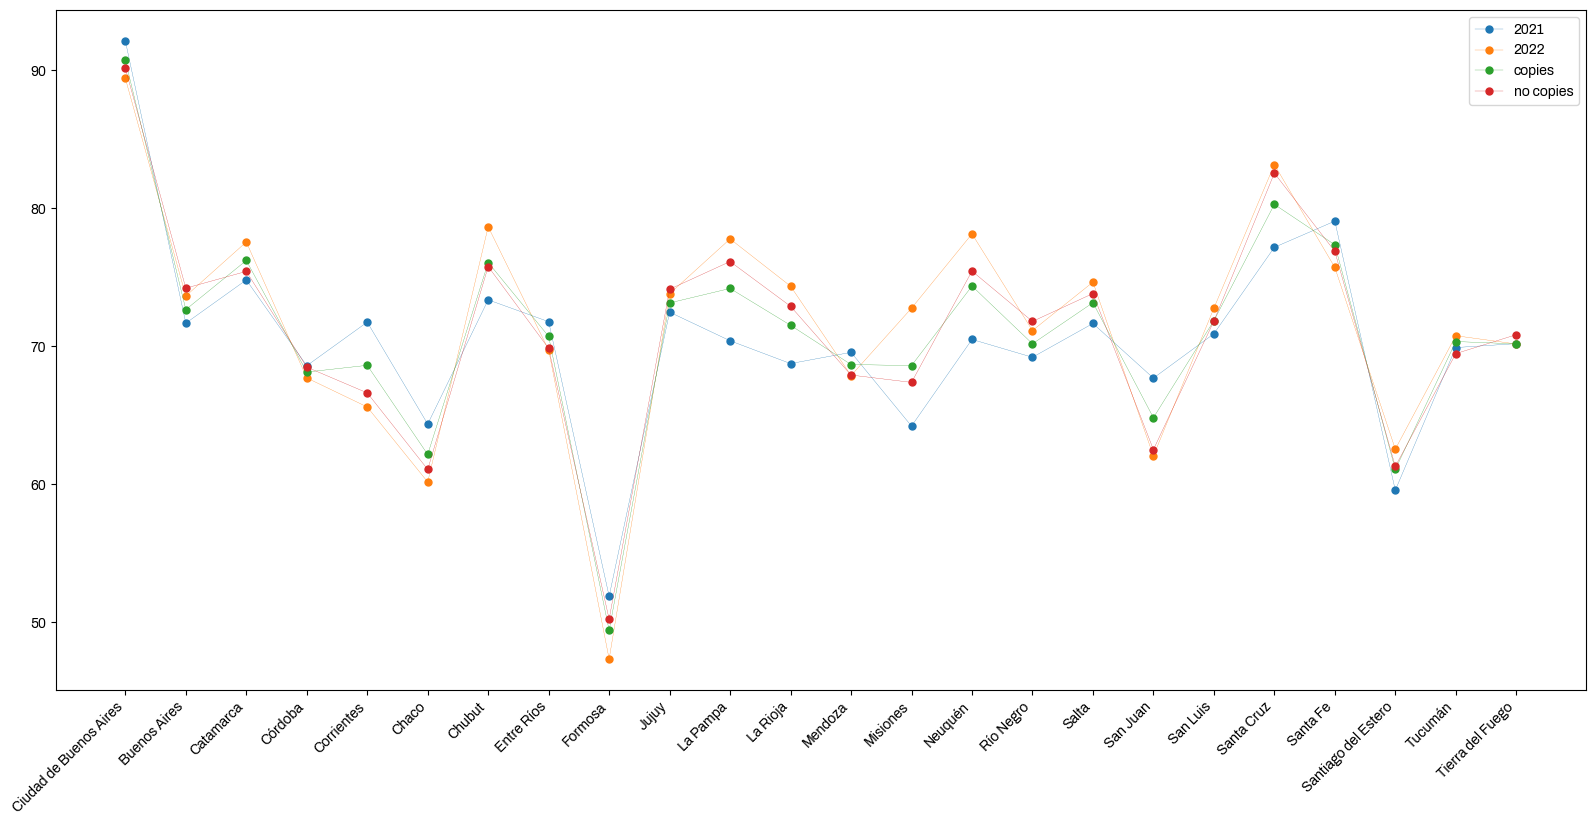

In [203]:
fig = plt.figure(figsize=(18, 8))
ax = plt.axes([0.05, 0.05, 0.85, 0.85])
ax.plot(comparacion_indicadores.columns, comparacion_indicadores.T.values, marker='.', markersize=10, lw=0.2, label=['2021', '2022', 'copies', 'no copies'])
ax.legend()
for label in ax.get_xticklabels():
  label.set_rotation(45)
  label.set_ha('right')

In [207]:
comparacion_indicadores = pd.DataFrame([df_ratio_2021['Acceso a derechos laborales'], 
        df_ratio_2022['Acceso a derechos laborales'], 
        df_ratio_with_copies['Acceso a derechos laborales'],
        df_ratio_without_copies['Acceso a derechos laborales']])
comparacion_indicadores

Nombre,Ciudad de Buenos Aires,Buenos Aires,Catamarca,Córdoba,Corrientes,Chaco,Chubut,Entre Ríos,Formosa,Jujuy,...,Neuquén,Río Negro,Salta,San Juan,San Luis,Santa Cruz,Santa Fe,Santiago del Estero,Tucumán,Tierra del Fuego
Acceso a derechos laborales,94.378673,92.330813,104.334782,90.888590,97.700547,124.160572,91.600942,92.638600,108.371130,103.952343,...,86.423935,103.598180,88.853197,98.722945,83.908467,89.951424,91.678771,93.563663,93.375876,93.603555
Acceso a derechos laborales,92.995828,94.950498,92.686144,98.329853,97.227706,117.546250,86.449071,83.590235,117.845471,97.760338,...,91.204191,98.488582,92.671860,99.766233,85.224935,95.382759,86.180631,86.641088,89.521708,95.455898
Acceso a derechos laborales,93.680589,93.605479,97.981963,94.573139,97.458559,120.795204,88.856211,88.041183,113.205593,100.604170,...,88.909599,100.953429,90.786782,99.336025,84.625383,92.807127,88.760503,90.248334,91.319016,94.597706
Acceso a derechos laborales,95.525450,94.454462,97.804807,92.570566,97.292316,125.340199,90.016059,86.245691,114.256045,95.150976,...,89.678835,103.513369,85.223032,101.753466,85.547977,91.192525,87.170614,89.027497,90.699947,94.555752


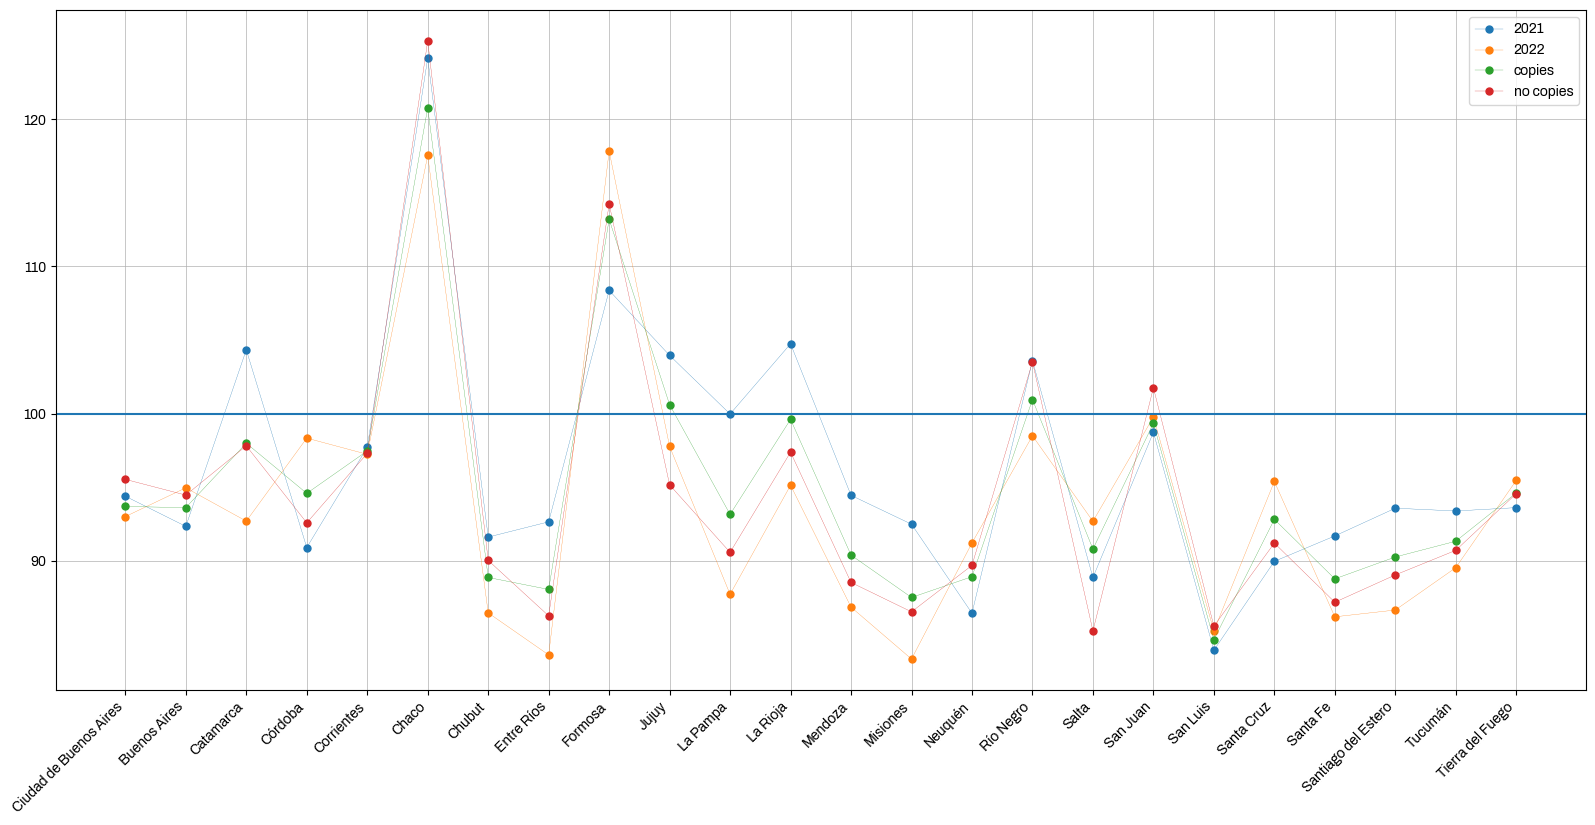

In [215]:
fig = plt.figure(figsize=(18, 8))
ax = plt.axes([0.05, 0.05, 0.85, 0.85])
ax.plot(comparacion_indicadores.columns, comparacion_indicadores.T.values, marker='.', markersize=10, lw=0.2, label=['2021', '2022', 'copies', 'no copies'])
ax.legend()
ax.grid(lw=.5)
ax.axhline(y=100)
for label in ax.get_xticklabels():
  label.set_rotation(45)
  label.set_ha('right')

In [216]:
comparacion_indicadores = pd.DataFrame([df_ratio_2021['Búsqueda de trabajo'], 
        df_ratio_2022['Búsqueda de trabajo'], 
        df_ratio_with_copies['Búsqueda de trabajo'],
        df_ratio_without_copies['Búsqueda de trabajo']])
comparacion_indicadores

Nombre,Ciudad de Buenos Aires,Buenos Aires,Catamarca,Córdoba,Corrientes,Chaco,Chubut,Entre Ríos,Formosa,Jujuy,...,Neuquén,Río Negro,Salta,San Juan,San Luis,Santa Cruz,Santa Fe,Santiago del Estero,Tucumán,Tierra del Fuego
Búsqueda de trabajo,143.408430,76.737452,62.304473,53.736201,190.514579,103.363918,131.096370,57.776366,220.595458,54.492848,...,76.511448,74.835674,80.891234,104.767300,152.857128,164.652641,70.011791,103.846527,92.927126,94.267248
Búsqueda de trabajo,161.520979,76.356595,64.946190,53.255625,93.142920,86.465544,205.959972,66.777726,380.957724,84.798776,...,105.078845,90.285319,105.969199,65.448033,74.979522,143.220792,84.276075,367.568028,92.813578,73.517332
Búsqueda de trabajo,150.000692,76.544203,63.689633,53.249868,125.562305,97.347965,157.300883,61.508738,258.149536,69.942669,...,87.488850,83.055346,92.269829,86.827453,119.496705,152.608273,75.663649,166.453993,92.890378,82.798724
Búsqueda de trabajo,124.887820,79.009965,59.028969,52.713841,108.179728,116.931767,140.003129,51.987171,247.494631,83.542735,...,103.168765,85.537929,87.331183,86.037937,90.568509,165.231920,74.694020,158.005410,89.859773,74.509077


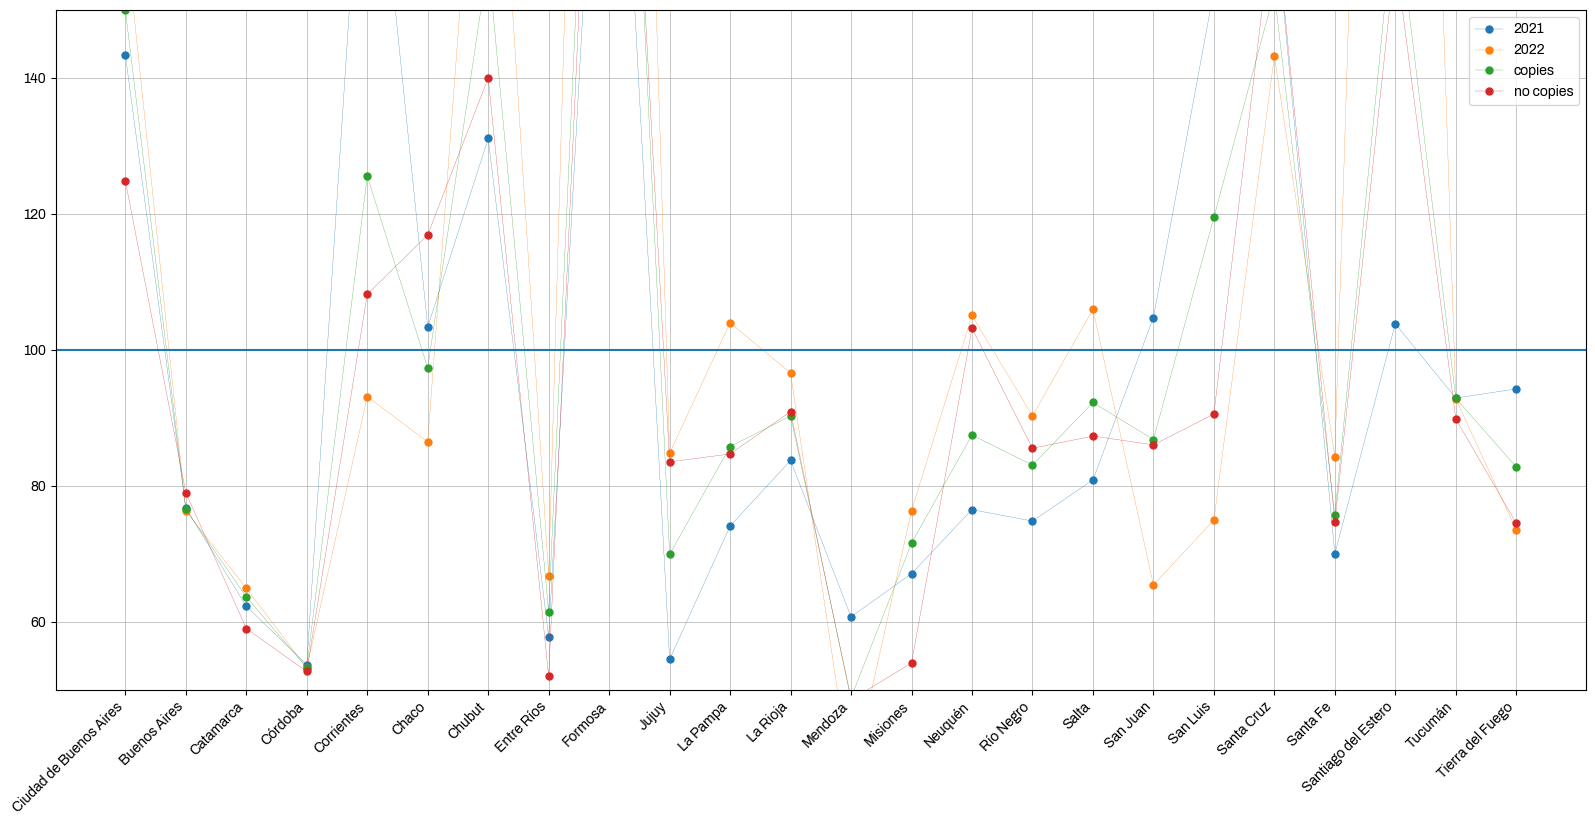

In [218]:
fig = plt.figure(figsize=(18, 8))
ax = plt.axes([0.05, 0.05, 0.85, 0.85])
ax.plot(comparacion_indicadores.columns, comparacion_indicadores.T.values, marker='.', markersize=10, lw=0.2, label=['2021', '2022', 'copies', 'no copies'])
ax.legend()
ax.grid(lw=.5)
ax.axhline(y=100)
ax.set_ylim([50,150])
for label in ax.get_xticklabels():
  label.set_rotation(45)
  label.set_ha('right')

In [219]:
comparacion_indicadores = pd.DataFrame([df_ratio_2021['Participación en el trabajo remunerado'], 
        df_ratio_2022['Participación en el trabajo remunerado'], 
        df_ratio_with_copies['Participación en el trabajo remunerado'],
        df_ratio_without_copies['Participación en el trabajo remunerado']])
comparacion_indicadores

Nombre,Ciudad de Buenos Aires,Buenos Aires,Catamarca,Córdoba,Corrientes,Chaco,Chubut,Entre Ríos,Formosa,Jujuy,...,Neuquén,Río Negro,Salta,San Juan,San Luis,Santa Cruz,Santa Fe,Santiago del Estero,Tucumán,Tierra del Fuego
Participación en el trabajo remunerado,104.615024,92.303697,103.003372,89.369581,104.433645,89.218701,88.424742,92.835137,100.375501,90.903647,...,88.964642,87.843632,89.720809,99.902292,99.507381,84.310852,100.862622,96.147696,94.834349,92.898207
Participación en el trabajo remunerado,101.292420,92.027405,96.528609,91.472378,94.880948,86.280021,90.110331,98.627059,95.457392,83.156534,...,93.824243,92.897581,94.210355,100.125514,99.180304,93.884540,93.834663,92.985882,94.826266,90.978035
Participación en el trabajo remunerado,102.990062,92.137577,99.772082,90.381444,99.575319,87.658530,89.497689,95.947252,97.502994,87.011098,...,91.685654,90.400773,91.971738,99.775971,99.476254,89.109279,97.261004,94.810865,94.831098,91.937242
Participación en el trabajo remunerado,102.178071,92.970074,98.758801,90.609111,97.336206,86.698543,88.908224,96.984843,96.941583,87.453644,...,92.860283,91.702354,92.573842,98.807426,99.586977,90.703519,95.112890,93.506379,94.038442,92.105119


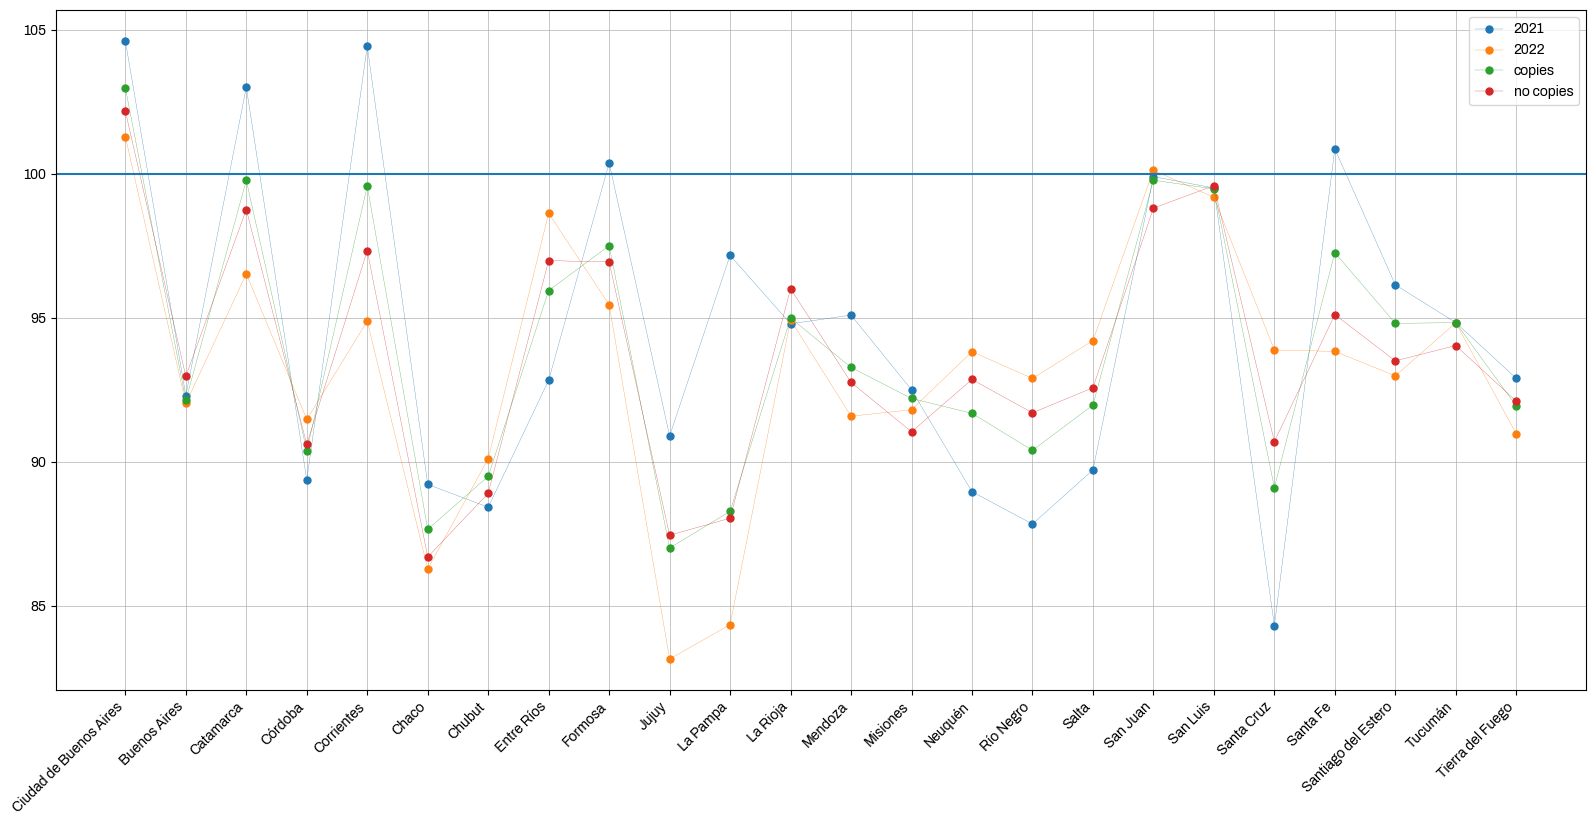

In [220]:
fig = plt.figure(figsize=(18, 8))
ax = plt.axes([0.05, 0.05, 0.85, 0.85])
ax.plot(comparacion_indicadores.columns, comparacion_indicadores.T.values, marker='.', markersize=10, lw=0.2, label=['2021', '2022', 'copies', 'no copies'])
ax.legend()
ax.grid(lw=.5)
ax.axhline(y=100)
#ax.set_ylim([50,150])
for label in ax.get_xticklabels():
  label.set_rotation(45)
  label.set_ha('right')